Nour Mansour and Juan Estrella

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns

Part 1: Data Collection

Step 1: Get the tsv data

In [2]:
# Data is saved in the same folder as the project. Then read data from tsv file
data = pd.read_csv("train-balanced-sarcasm.csv")

Part 2: Data Processing

Step 1: Columns required: Label, Comments, subreddit, parent comment

Step 2: Create a Dataframe containing an even amount of sarcastic and non sarcastic 
comments, amount of data is 505413 each. 

In [3]:
# Reset the indices after rows with NA values are dropped
data.dropna(inplace=True)
data.drop(['author', 'score', 'ups', 'downs', 'date', 'created_utc', 'subreddit', 'parent_comment'], axis = 1, inplace = True)
data.reset_index(inplace = True)
data.drop(['index'], axis = 1, inplace = True)
data.head()

,label,comment
0,0,NC and NH.
1,0,You do know west teams play against west teams...
2,0,"They were underdogs earlier today, but since G..."
3,0,"This meme isn't funny none of the ""new york ni..."
4,0,I could use one of those tools.


In [4]:
#data.groupby('label').describe()

We really wanted to use the entire dataset, unfortunately our laptops weren't strong enough to perform the different types of data manipulation and analysis we wanted. 
As a solution, we decided to sample 10% of the dataset each time we ran the program. 10% was actually the largest sample we could get without our Jupyter kernel dying from overflowing Docker's allocated memory resources (we set the memory for Docker to the max value possible given our laptops' specs!). 

In [5]:
# Determine size and replacement values
size = int(len(data)*5/100)# sample size
replace = True  # with replacement
# Function used to pick random rows from the dataset
# We used the groupby('label') function to choose equal numbers 
# of sarcastic and non-sarcastic comments
fun = lambda obj: obj.loc[np.random.choice(obj.index, size, replace),:]
chosen_data = data.groupby('label', as_index=False).apply(fun)
chosen_data.head()

label                                            comment
0 840501      0  Eat your fiber kids, no seriously when you hit...
  863979      0        OP needs to lighten up and smell the bacon.
  963770      0  there is plenty of micro-debris that they can'...
  973656      0  Please know the difference between nose guns a...
  833966      0  That would be absolutely traumatizing for sold...

In [6]:
# Reset the indexes to remove the grouping into 0s and 1s
chosen_data.reset_index(inplace = True)
# Delete the columns that include the names of the indexes created from the groups
chosen_data.drop(['level_0', 'level_1'], inplace = True, axis = 1)
chosen_data.head()

,label,comment
0,0,"Eat your fiber kids, no seriously when you hit..."
1,0,OP needs to lighten up and smell the bacon.
2,0,there is plenty of micro-debris that they can'...
3,0,Please know the difference between nose guns a...
4,0,That would be absolutely traumatizing for sold...


In [7]:
chosen_data.tail()

,label,comment
101071,1,must be a smart and rich kid
101072,1,Minesweeper
101073,1,Sounds wonderful.
101074,1,"Yeah, and I'm a black nationalist because some..."
101075,1,"Because they have Jesus, they don't need no fa..."


Part 3: Exploratory Analysis & Data Visualization

We made sure we got equal number of sarcastic and non-sarcastic comments. From the following histogram, we notice we got 50,000 comments from each group.

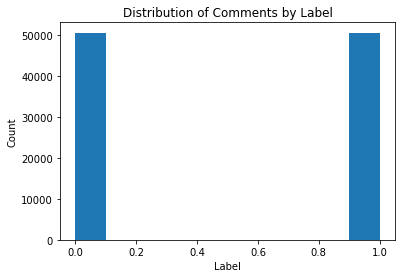

comment                            
        count unique             top freq
label                                    
0       50538  46904             Yes   47
1       50538  47226  You forgot the  149

In [8]:
# Explore distribution of the data by label (0 -> non-sarcastic, 1 -> sarcastic)
plt.hist(chosen_data.label)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Comments by Label')
plt.show()

# Explore distribution of comments by label 
chosen_data.groupby('label').describe()

In [9]:
#Import NLTK library
!pip install nltk

In [10]:
import nltk

In [11]:
nltk.download("all")

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /home/jovyan/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /home/jovyan/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /home/jovyan/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to
[nltk_data]    |     /home/jovyan/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to
[nltk_data]    |     /home/jovyan/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to
[nltk_data]    |     /home/jovyan/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package

[nltk_data]    |   Package semcor is already up-to-date!
[nltk_data]    | Downloading package senseval to
[nltk_data]    |     /home/jovyan/nltk_data...
[nltk_data]    |   Package senseval is already up-to-date!
[nltk_data]    | Downloading package sentiwordnet to
[nltk_data]    |     /home/jovyan/nltk_data...
[nltk_data]    |   Package sentiwordnet is already up-to-date!
[nltk_data]    | Downloading package sentence_polarity to
[nltk_data]    |     /home/jovyan/nltk_data...
[nltk_data]    |   Package sentence_polarity is already up-to-date!
[nltk_data]    | Downloading package shakespeare to
[nltk_data]    |     /home/jovyan/nltk_data...
[nltk_data]    |   Package shakespeare is already up-to-date!
[nltk_data]    | Downloading package sinica_treebank to
[nltk_data]    |     /home/jovyan/nltk_data...
[nltk_data]    |   Package sinica_treebank is already up-to-date!
[nltk_data]    | Downloading package smultron to
[nltk_data]    |     /home/jovyan/nltk_data...
[nltk_data]    |   Package

True

In [12]:
from nltk.corpus import stopwords #Use this to get rid of meaningless words like "the, and, a"
from nltk.tokenize import word_tokenize #Split by word
from nltk.tokenize import sent_tokenize #Split by sentence

In [13]:
#Make sure all the comment column is str data type
chosen_data['comment'] = chosen_data['comment'].astype(str)
chosen_data['comment'] = chosen_data['comment'].astype(str)

In [14]:
# Split the comments into words
chosen_data['token'] = chosen_data['comment'].apply(word_tokenize)
# Apply Parts of Speech tagging on the words
chosen_data['POS_tag'] = chosen_data['token'].apply(nltk.pos_tag)
chosen_data.head()

,label,comment,token,POS_tag
0,0,"Eat your fiber kids, no seriously when you hit...","[Eat, your, fiber, kids, ,, no, seriously, whe...","[(Eat, VB), (your, PRP$), (fiber, NN), (kids, ..."
1,0,OP needs to lighten up and smell the bacon.,"[OP, needs, to, lighten, up, and, smell, the, ...","[(OP, NNP), (needs, VBZ), (to, TO), (lighten, ..."
2,0,there is plenty of micro-debris that they can'...,"[there, is, plenty, of, micro-debris, that, th...","[(there, EX), (is, VBZ), (plenty, NN), (of, IN..."
3,0,Please know the difference between nose guns a...,"[Please, know, the, difference, between, nose,...","[(Please, VB), (know, VB), (the, DT), (differe..."
4,0,That would be absolutely traumatizing for sold...,"[That, would, be, absolutely, traumatizing, fo...","[(That, DT), (would, MD), (be, VB), (absolutel..."


In [15]:
# Apply stemming on the tokenized comments to get the roots of the words
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("english")

chosen_data['stem'] = chosen_data['token'].apply(lambda x: [stemmer.stem(y) for y in x])
chosen_data.head()

,label,comment,token,POS_tag,stem
0,0,"Eat your fiber kids, no seriously when you hit...","[Eat, your, fiber, kids, ,, no, seriously, whe...","[(Eat, VB), (your, PRP$), (fiber, NN), (kids, ...","[eat, your, fiber, kid, ,, no, serious, when, ..."
1,0,OP needs to lighten up and smell the bacon.,"[OP, needs, to, lighten, up, and, smell, the, ...","[(OP, NNP), (needs, VBZ), (to, TO), (lighten, ...","[op, need, to, lighten, up, and, smell, the, b..."
2,0,there is plenty of micro-debris that they can'...,"[there, is, plenty, of, micro-debris, that, th...","[(there, EX), (is, VBZ), (plenty, NN), (of, IN...","[there, is, plenti, of, micro-debri, that, the..."
3,0,Please know the difference between nose guns a...,"[Please, know, the, difference, between, nose,...","[(Please, VB), (know, VB), (the, DT), (differe...","[pleas, know, the, differ, between, nose, gun,..."
4,0,That would be absolutely traumatizing for sold...,"[That, would, be, absolutely, traumatizing, fo...","[(That, DT), (would, MD), (be, VB), (absolutel...","[that, would, be, absolut, traumat, for, soldi..."


### Predicting Sarcasm

We were interested in trying different models for predicting a sarcastic comment.
To determine the features and labels for the analysis, we decided to look at the comment itself as a feature and use the given sarcastic vs non-sarcastic classification as our label.

Various articles and studies looked at sarcasm and attempted to predict using different features. For instance, an online tutorial only looked at TF-IDF as a feature, so we decided we wanted to experiment with that and see if we would get anything remotely close to their findings. Worth noting, however, that they looked at tweets with the #sarcasm tag, their dataset was significantly smaller than ours (N= ), and their training vs test data split was slightly unusual (training = 95%, test = 5%). 

To create a more reliable model, we decided to split our data into the more common 80-20 split for training and test subsets respectively. We also chose three main models to compare, acknowledging that some of them might fare slightly more poorly compared to the others. We also assumed TF-IDF vectorization of the comments alone would not be a good predictor for whether a comment is sarcastic or not. 

The three models we picked were:
1. Logistic regression
2. Support Vector Machine
3. Random forest

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [17]:
# Determine the features and labels for the models
features = chosen_data['stem'].apply(lambda x: ' '.join(x))
labels = chosen_data['label']

In [18]:
#features

We vectorized the comments here and used the TF-IDF list as the feature in our model.

In [19]:
# TF-IDF to vectorize the data

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range = (2,2)) # ask about max features
features = list(features)
X = vectorizer.fit_transform(features)

In [20]:
#print(vectorizer.get_feature_names())
print(X.shape)

(101076, 342462)


In [21]:
#print(X)
# X.toarray() # it only works if it's an array but why does it become all 0s?
# X

In [22]:
#print(X)

In [23]:
chosen_data.head()

,label,comment,token,POS_tag,stem
0,0,"Eat your fiber kids, no seriously when you hit...","[Eat, your, fiber, kids, ,, no, seriously, whe...","[(Eat, VB), (your, PRP$), (fiber, NN), (kids, ...","[eat, your, fiber, kid, ,, no, serious, when, ..."
1,0,OP needs to lighten up and smell the bacon.,"[OP, needs, to, lighten, up, and, smell, the, ...","[(OP, NNP), (needs, VBZ), (to, TO), (lighten, ...","[op, need, to, lighten, up, and, smell, the, b..."
2,0,there is plenty of micro-debris that they can'...,"[there, is, plenty, of, micro-debris, that, th...","[(there, EX), (is, VBZ), (plenty, NN), (of, IN...","[there, is, plenti, of, micro-debri, that, the..."
3,0,Please know the difference between nose guns a...,"[Please, know, the, difference, between, nose,...","[(Please, VB), (know, VB), (the, DT), (differe...","[pleas, know, the, differ, between, nose, gun,..."
4,0,That would be absolutely traumatizing for sold...,"[That, would, be, absolutely, traumatizing, fo...","[(That, DT), (would, MD), (be, VB), (absolutel...","[that, would, be, absolut, traumat, for, soldi..."


In [24]:
# Split data into Training and Test data chosen_data[['comment', 'POS_tag', 'stem']]

X_train, X_test, y_train, y_test = train_test_split(X, chosen_data.label, test_size=0.2, random_state=0)

In [25]:
# Logistic Regression

log_clf = LogisticRegression(solver='lbfgs', max_iter = 300).fit(X_train, y_train)

In [26]:
# Predict the test values

log_clf.predict(X_test)

array([1, 0, 1, ..., 1, 0, 1])

In [27]:
# Logistic regression score
print(log_clf.score(X_train, y_train))
print(log_clf.score(X_test, y_test))

0.906492703438041
0.6832212109220419


In [28]:
# SVM model

svm_clf = LinearSVC()

In [29]:
# Training the model

svm_clf.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [30]:
print(svm_clf.score(X_train, y_train))
print(svm_clf.score(X_test, y_test))

0.9801508780608459
0.6808468539770479


In [31]:
# Random Forest Classifier

rf_clf = RandomForestClassifier(n_estimators = 10)

In [ ]:
rf_clf.fit(X_train, y_train)

In [ ]:
print(rf_clf.score(X_train, y_train))
print(rf_clf.score(X_test, y_test))

After confirming our suspicions that using TF-IDF on the raw tokenized comments would yield very modest results, we decided to continue exploring how we can fix our models. First, we used chunking to break up the comments into more meaningful noun phrases. 

In [34]:
# Use reg ex to chunk the sentences into noun phrases
np_chunking = "NP: {<DT>?<JJ>*<NN>}"
chunk_parser = nltk.RegexpParser(np_chunking)
chosen_data['noun_phrase_chunk'] = chosen_data['POS_tag'].apply(chunk_parser.parse)

Notice how the chunked sentences column groups the nouns into groups with

In [35]:
chosen_data.iloc[0:10, 2:5:2]

,token,stem
0,"[In, your, wallet, .]","[in, your, wallet, .]"
1,"[Internet, hug]","[internet, hug]"
2,"[Yes, .]","[yes, .]"
3,"[they, rush, and, pray, but, it, works, .]","[they, rush, and, pray, but, it, work, .]"
4,"[At, least, he, would, n't, lie, about, it, .]","[at, least, he, would, n't, lie, about, it, .]"
5,"[so, ,, you, get, paid, for, owning, it, ?]","[so, ,, you, get, paid, for, own, it, ?]"
6,"[You, should, be, fine, .]","[you, should, be, fine, .]"
7,"[And, it, ca, n't, be, made, into, effective, ...","[and, it, ca, n't, be, made, into, effect, wea..."
8,"[Yep, ,, this, is, definitely, Berner, territo...","[yep, ,, this, is, definit, berner, territori, .]"
9,"[Apparently, the, three, window, limit, includ...","[appar, the, three, window, limit, includ, the..."


In [36]:
chosen_data.tail()

,label,comment,token,POS_tag,stem,noun_phrase_chunk
151609,1,"Yeah Villanova played like shit today, they go...","[Yeah, Villanova, played, like, shit, today, ,...","[(Yeah, UH), (Villanova, NNP), (played, VBD), ...","[yeah, villanova, play, like, shit, today, ,, ...","[(Yeah, UH), (Villanova, NNP), (played, VBD), ..."
151610,1,"Nah, they should nerf the AWP because it kills...","[Nah, ,, they, should, nerf, the, AWP, because...","[(Nah, NNP), (,, ,), (they, PRP), (should, MD)...","[nah, ,, they, should, nerf, the, awp, becaus,...","[(Nah, NNP), (,, ,), (they, PRP), (should, MD)..."
151611,1,So you're an honest asshole?,"[So, you, 're, an, honest, asshole, ?]","[(So, RB), (you, PRP), ('re, VBP), (an, DT), (...","[so, you, re, an, honest, asshol, ?]","[(So, RB), (you, PRP), ('re, VBP), [(an, DT), ..."
151612,1,"Only America and the middle east is the world,...","[Only, America, and, the, middle, east, is, th...","[(Only, RB), (America, NNP), (and, CC), (the, ...","[onli, america, and, the, middl, east, is, the...","[(Only, RB), (America, NNP), (and, CC), [(the,..."
151613,1,"Your so called ""good boy points"" are fucking w...","[Your, so, called, ``, good, boy, points, '', ...","[(Your, PRP$), (so, RB), (called, VBN), (``, `...","[your, so, call, ``, good, boy, point, '', are...","[(Your, PRP$), (so, RB), (called, VBN), (``, `..."


In [37]:
joined_tag = []
for index, row in chosen_data.iterrows():
    joined_tag.append(' '.join([word + "_" + pos for word, pos in row['POS_tag']]))
chosen_data['joined_POS_tag'] = joined_tag.copy()

In [38]:
chosen_data.head()

,label,comment,token,POS_tag,stem,noun_phrase_chunk,joined_POS_tag
0,0,In your wallet.,"[In, your, wallet, .]","[(In, IN), (your, PRP$), (wallet, NN), (., .)]","[in, your, wallet, .]","[(In, IN), (your, PRP$), [(wallet, NN)], (., .)]",In_IN your_PRP$ wallet_NN ._.
1,0,Internet hug,"[Internet, hug]","[(Internet, NNP), (hug, NN)]","[internet, hug]","[(Internet, NNP), [(hug, NN)]]",Internet_NNP hug_NN
2,0,Yes.,"[Yes, .]","[(Yes, UH), (., .)]","[yes, .]","[(Yes, UH), (., .)]",Yes_UH ._.
3,0,they rush and pray but it works.,"[they, rush, and, pray, but, it, works, .]","[(they, PRP), (rush, VBP), (and, CC), (pray, V...","[they, rush, and, pray, but, it, work, .]","[(they, PRP), (rush, VBP), (and, CC), (pray, V...",they_PRP rush_VBP and_CC pray_VBP but_CC it_PR...
4,0,At least he wouldn't lie about it.,"[At, least, he, would, n't, lie, about, it, .]","[(At, IN), (least, JJS), (he, PRP), (would, MD...","[at, least, he, would, n't, lie, about, it, .]","[(At, IN), (least, JJS), (he, PRP), (would, MD...",At_IN least_JJS he_PRP would_MD n't_RB lie_VB ...


In [39]:
features2 = chosen_data['joined_POS_tag']
features2 = list(features2)
X2 = vectorizer.fit_transform(features2)

In [40]:
# Split data into Training and Test data chosen_data[['comment', 'POS_tag', 'stem']]

X_train, X_test, y_train, y_test = train_test_split(X2, chosen_data.label, test_size=0.2, random_state=0)

In [41]:
# Logistic Regression

log_clf = LogisticRegression(solver='lbfgs', max_iter = 300).fit(X_train, y_train)

print(log_clf.score(X_train, y_train))
print(log_clf.score(X_test, y_test))

0.7813770189049476
0.685980938561488


In [42]:
# SVM model
svm_clf = LinearSVC()

# Training the model
svm_clf.fit(X_train, y_train)

print(svm_clf.score(X_train, y_train))
print(svm_clf.score(X_test, y_test))

0.8720927356522743
0.6855522210863041


In [43]:
# Random Forest Classifier

rf_clf = RandomForestClassifier(n_estimators = 10)

rf_clf.fit(X_train, y_train)

print(rf_clf.score(X_train, y_train))
print(rf_clf.score(X_test, y_test))

0.980781756272106
0.683573525046994


In [49]:
!pip install -U textblob
from textblob import TextBlob

     |████████████████████████████████| 645kB 1.4MB/s eta 0:00:01


In [50]:
blob_list = []
for index, row in chosen_data.iterrows():
    blob_list.append(TextBlob(row['comment']))
chosen_data['textblob'] = blob_list.copy()

In [51]:
chosen_data.head()

,label,comment,token,POS_tag,stem,noun_phrase_chunk,joined_POS_tag,textblob
0,0,In your wallet.,"[In, your, wallet, .]","[(In, IN), (your, PRP$), (wallet, NN), (., .)]","[in, your, wallet, .]","[(In, IN), (your, PRP$), [(wallet, NN)], (., .)]",In_IN your_PRP$ wallet_NN ._.,"(I, n, , y, o, u, r, , w, a, l, l, e, t, .)"
1,0,Internet hug,"[Internet, hug]","[(Internet, NNP), (hug, NN)]","[internet, hug]","[(Internet, NNP), [(hug, NN)]]",Internet_NNP hug_NN,"(I, n, t, e, r, n, e, t, , h, u, g)"
2,0,Yes.,"[Yes, .]","[(Yes, UH), (., .)]","[yes, .]","[(Yes, UH), (., .)]",Yes_UH ._.,"(Y, e, s, .)"
3,0,they rush and pray but it works.,"[they, rush, and, pray, but, it, works, .]","[(they, PRP), (rush, VBP), (and, CC), (pray, V...","[they, rush, and, pray, but, it, work, .]","[(they, PRP), (rush, VBP), (and, CC), (pray, V...",they_PRP rush_VBP and_CC pray_VBP but_CC it_PR...,"(t, h, e, y, , r, u, s, h, , a, n, d, , p, ..."
4,0,At least he wouldn't lie about it.,"[At, least, he, would, n't, lie, about, it, .]","[(At, IN), (least, JJS), (he, PRP), (would, MD...","[at, least, he, would, n't, lie, about, it, .]","[(At, IN), (least, JJS), (he, PRP), (would, MD...",At_IN least_JJS he_PRP would_MD n't_RB lie_VB ...,"(A, t, , l, e, a, s, t, , h, e, , w, o, u, ..."


In [52]:
polarity_list = []
for index, row in chosen_data.iterrows():
    polarity_list.append(row['textblob'].sentiment.polarity)

In [53]:
chosen_data['polarity'] = polarity_list.copy()

In [54]:
chosen_data.head()

,label,comment,token,POS_tag,stem,noun_phrase_chunk,joined_POS_tag,textblob,polarity
0,0,In your wallet.,"[In, your, wallet, .]","[(In, IN), (your, PRP$), (wallet, NN), (., .)]","[in, your, wallet, .]","[(In, IN), (your, PRP$), [(wallet, NN)], (., .)]",In_IN your_PRP$ wallet_NN ._.,"(I, n, , y, o, u, r, , w, a, l, l, e, t, .)",0.0
1,0,Internet hug,"[Internet, hug]","[(Internet, NNP), (hug, NN)]","[internet, hug]","[(Internet, NNP), [(hug, NN)]]",Internet_NNP hug_NN,"(I, n, t, e, r, n, e, t, , h, u, g)",0.0
2,0,Yes.,"[Yes, .]","[(Yes, UH), (., .)]","[yes, .]","[(Yes, UH), (., .)]",Yes_UH ._.,"(Y, e, s, .)",0.0
3,0,they rush and pray but it works.,"[they, rush, and, pray, but, it, works, .]","[(they, PRP), (rush, VBP), (and, CC), (pray, V...","[they, rush, and, pray, but, it, work, .]","[(they, PRP), (rush, VBP), (and, CC), (pray, V...",they_PRP rush_VBP and_CC pray_VBP but_CC it_PR...,"(t, h, e, y, , r, u, s, h, , a, n, d, , p, ...",0.0
4,0,At least he wouldn't lie about it.,"[At, least, he, would, n't, lie, about, it, .]","[(At, IN), (least, JJS), (he, PRP), (would, MD...","[at, least, he, would, n't, lie, about, it, .]","[(At, IN), (least, JJS), (he, PRP), (would, MD...",At_IN least_JJS he_PRP would_MD n't_RB lie_VB ...,"(A, t, , l, e, a, s, t, , h, e, , w, o, u, ...",-0.3


In [55]:
blob = TextBlob("this is a great sentence")
blob.sentiment.polarity

0.8

In [1]:
print(chosen_data['polarity'].shape)

NameError: name 'chosen_data' is not defined